In [158]:
import vitaldb
import numpy as np
import pandas as pd
import scipy.signal as ss
from scipy.ndimage import minimum_filter1d, maximum_filter1d
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

# colorblind friendly palette
import matplotlib as mpl
cp = ["#172A5A", "#FF7171", "#227567", "#34BAEA", "#F9D466", ]
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=cp)

# set default font
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Open Sans', 'Arial']
plt.rcParams['figure.figsize'] = [10, 5]


In [159]:
class VitalDataProcessor:
    
    def __init__(self, track_names, fs=125):
        self.track_names = track_names
        self.fs = fs
        self.data = None
        self.caseids = None
        self.t = None
        self.ecg = None
        self.art = None
        self.ppg = None
        
    def load_vitaldB(self):
        df_trks = pd.read_csv('https://api.vitaldb.net/trks')  # read track list
        df_cases = pd.read_csv("https://api.vitaldb.net/cases")  # read case information
        
        self.caseids = list(
            set(df_trks[df_trks['tname'] == 'SNUADC/ART']['caseid']) &
            set(df_trks[df_trks['tname'] == 'SNUADC/ECG_II']['caseid']) &
            set(df_trks[df_trks['tname'] == 'SNUADC/PLETH']['caseid']) &
            set(df_cases[df_cases['age'] > 18]['caseid']) &
            set(df_cases[df_cases['age'] >= 18]['caseid']) & 
            set(df_cases[df_cases['weight'] >= 30]['caseid']) & 
            set(df_cases[df_cases['weight'] < 140]['caseid']) & 
            set(df_cases[df_cases['height'] >= 135]['caseid']) & 
            set(df_cases[df_cases['height'] < 200]['caseid']) & 
            set(df_cases[~df_cases['opname'].str.contains("transplant", case=False)]['caseid']) & 
            set(df_cases[~df_cases['opname'].str.contains("aneurysm", case=False)]['caseid']) & 
            set(df_cases[~df_cases['opname'].str.contains("aorto", case=False)]['caseid'])& 
            set(df_cases[df_cases['ane_type'] == 'General']['caseid'])
            )
        
    def load_patient_data(self, cid, output=False):
        assert(self.caseids is not None)
        
        vf = vitaldb.VitalFile(self.caseids[cid], self.track_names)
        self.data = vf.to_numpy(self.track_names, 1/self.fs)
        self.t = np.arange(self.data.shape[0]) / self.fs
        self.ecg = self.data[:,0]
        self.art = self.data[:,1]
        self.ppg = self.data[:,2]
        
        if output:
            return self.ecg, self.art, self.ppg
        return 0
    
    def remove_baseline_fluctuation(self, filt_type = "savgol", window_size = 21, polyorder = 1, cutoff=0.5, output=False):
        if filt_type == "highpass":
            nyquist = self.fs/2
            b, a = ss.butter(2, cutoff/nyquist, btype='highpass')
            ecg_corrected = ss.filtfilt(b, a, self.ecg)
            ppg_corrected = ss.filtfilt(b, a, self.ppg)
        elif filt_type == "median":
            ecg_filt = ss.medfilt(self.ecg, window_size)
            ppg_filt = ss.medfilt(self.ppg, window_size)
            ecg_corrected = self.ecg - ecg_filt + np.mean(ecg_filt)
            ppg_corrected = self.ppg - ppg_filt + np.mean(ppg_filt)
            # ecg_median = ss.medfilt(self.ecg, window_size)
            # ppg_median = ss.medfilt(self.ppg, window_size)
            # ecg_corrected = self.ecg - ecg_median
            # ppg_corrected = self.ppg - ppg_median
        else:
            raise ValueError("filt_type must be 'savgol' or 'median'")
        
        self.ecg = ecg_corrected
        self.ppg = ppg_corrected
        
        if output:
            return ecg_corrected, ppg_corrected
        else:
            return 0
    
    # def remove_incorrect_heartrates(self, hr_min=40, hr_max=200):
    #     #Hunter's code
    #     hr = 60 / np.diff(self.rpeaks)
    #     hr = np.append(hr, hr[-1])
    #     self.rpeaks = self.rpeaks[(hr > hr_min) & (hr < hr_max)]
        
    def remove_saturated_regions(self, multiplier):
        ecg_clean = np.copy(self.ecg)
        # ppg_clean = np.copy(self.ppg)
        # art_clean = np.copy(self.art)
        
        ecg_threshold = np.nanmean(ecg_clean) + multiplier*np.nanstd(ecg_clean)
        # ppg_threshold = np.mean(ppg_clean) + multiplier*np.std(ppg_clean)
        # art_threshold = np.mean(art_clean) + multiplier*np.std(art_clean)
        
        saturated_mask = np.abs(ecg_clean) > ecg_threshold
        # saturated_mask |= np.abs(ppg_clean) > ppg_threshold
        # saturated_mask |= np.abs(art_clean) > art_threshold
        print(ecg_threshold)
        ecg_clean[saturated_mask] = np.nan
        # ppg_clean[saturated_mask] = np.nan
        # art_clean[saturated_mask] = np.nan
        
        # plt.plot(self.t, ecg_clean)
        #plt.plot(self.t, self.ecg)
        
        self.ecg = ecg_clean
        # self.art = art_clean
        # self.ppg = ppg_clean
        
        return ecg_clean, self.t
        
        
    def um(self, ta=None, tb=None):
        ta = ta if ta else self.t.min()
        tb = tb if tb else self.t.max()
        twin = (self.t >= ta) & (self.t <= tb)

        plt.figure(figsize=(12,8), dpi=100)
        for i, sig in enumerate([self.ecg, self.art, self.ppg]):
            sig = np.ma.masked_invalid(sig)
            plt.subplot(3,1,i+1)
            plt.plot(self.t[twin], sig[twin], lw=1, c=cp[i])
            sns.despine(bottom=i<2)
            if i<2: plt.xticks([])
            plt.xlim(ta, tb)
        plt.tight_layout()
        plt.show()
        
    

In [160]:
process_data = VitalDataProcessor(['SNUADC/ECG_II', 'SNUADC/ART', 'SNUADC/PLETH'])
process_data.load_vitaldB()

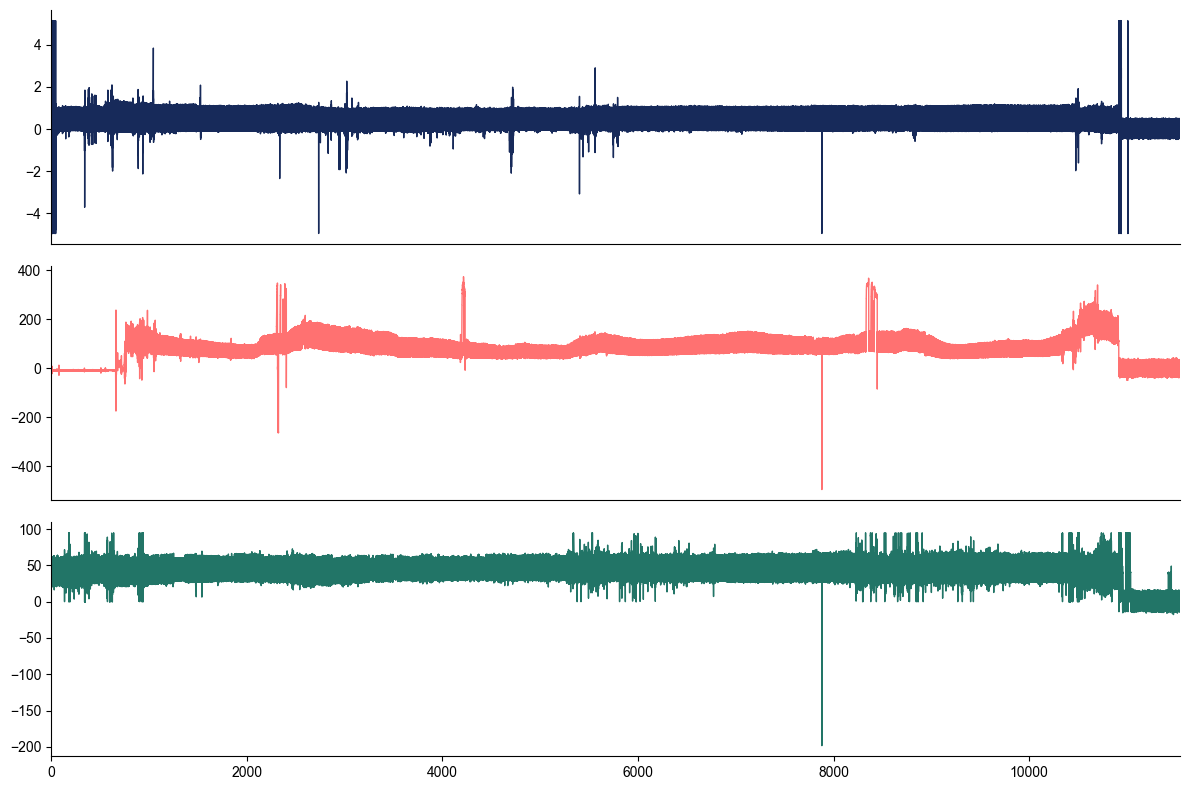

In [161]:
ecg, art, ppg = process_data.load_patient_data(0, True)
process_data.um()


ecg, ppg = process_data.remove_baseline_fluctuation(filt_type="median", output=True)
process_data.um(60*30, 60*31)

hello
0.5581905730068684
0
[-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- -- -- -- 0.5438759922981262 0.5142520070075989
 0.494502991437912 0.494502991437912 0.5142520070075989
 0.46487900614738464 0.40563198924064636 0.35625898838043213
 0.3463839888572693 0.3463839888572693 0.3365100026130676
 0.31676098704338074 0.3068859875202179 0.2871370017528534
 0.2871370017528534 0.2871370017528534 0.2871370017528534
 0.2871370017528534 0.247639000415802 0.23776400089263916
 0.2673879861831665 0.29701098799705505 0.29701098799705505
 0.2871370017528534 0.25751298666000366 0.247639000415802
 0.22788900136947632 0.20814000070095062 0.17851699888706207
 0.1

[]

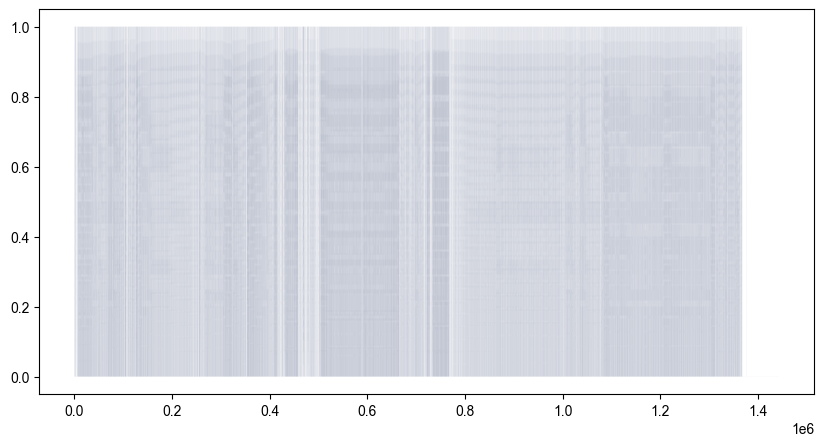

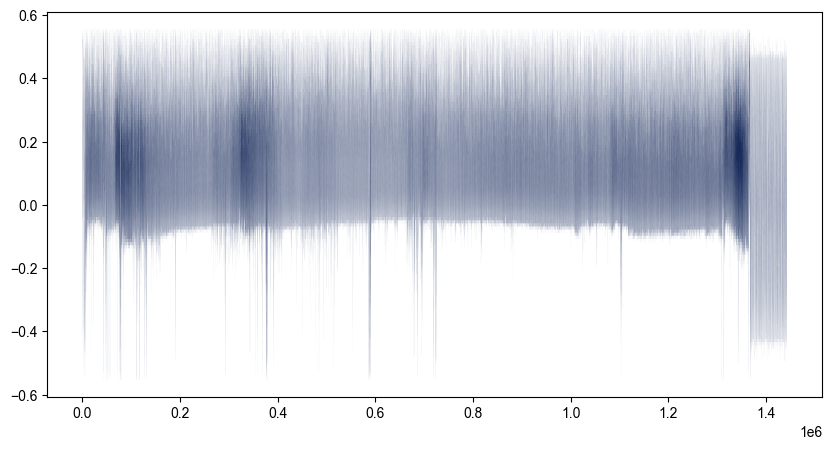

In [189]:


print("hello")
ecg_clean, time = process_data.remove_saturated_regions(multiplier=5)

# count number of nan values in ecg_clean
num_nans = np.count_nonzero(np.isnan(time))



print(num_nans)

sig=np.ma.masked_invalid(ecg_clean)
print(sig[1:500])
print(time)

# plot the densities of the nan values in sig

fig, ax = plt.subplots()
ax.plot(np.isnan(ecg_clean), lw = 0.01)


fig, ax = plt.subplots()
ax.plot(np.arange(len(sig)), sig, lw=0.01)
# change ylim to be from -5 to 5
plt.plot()


IndexError: tuple index out of range

(20,) (20,)


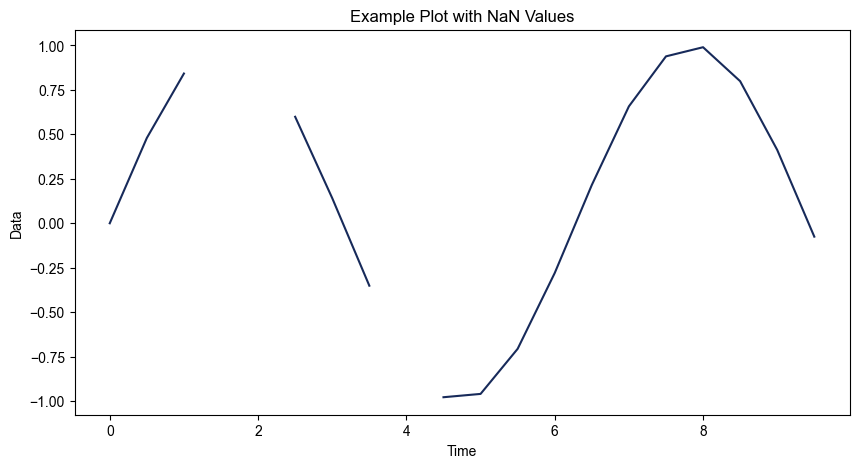

In [177]:
import numpy as np
import matplotlib.pyplot as plt

# Generate example data
x = np.arange(0, 10, 0.5)
y = np.sin(x)

# Add some NaN values to y
y[3:5] = np.nan
y[8] = np.nan

# Create a masked array where NaN values are masked
masked_y = np.ma.masked_invalid(y)

# Plot the masked array
plt.plot(x, masked_y)

# Add axis labels and title
plt.xlabel('Time')
plt.ylabel('Data')
plt.title('Example Plot with NaN Values')

# Show the plot
plt.show()

In [174]:
print(y)
print(masked_y)

[ 0.          0.47942554  0.84147098         nan         nan  0.59847214
  0.14112001 -0.35078323         nan -0.97753012 -0.95892427 -0.70554033
 -0.2794155   0.21511999  0.6569866   0.93799998  0.98935825  0.79848711
  0.41211849 -0.07515112]
[0.0 0.479425538604203 0.8414709848078965 -- -- 0.5984721441039564
 0.1411200080598672 -0.35078322768961984 -- -0.977530117665097
 -0.9589242746631385 -0.7055403255703919 -0.27941549819892586
 0.21511998808781552 0.6569865987187891 0.9379999767747389
 0.9893582466233818 0.7984871126234903 0.4121184852417566
 -0.07515112046180931]
